In [69]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [70]:
import numpy as np
import networkx as nx

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import MessagePassing

In [71]:
from envs.GraphEnv.impnode import ImpnodeEnv

seed = 5545

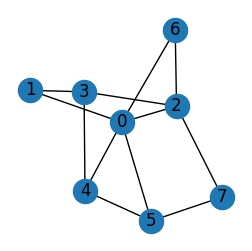

In [72]:
env = ImpnodeEnv(ba_nodes = 8,ba_edges = 2,max_removed_nodes = 3, seed=seed, render_option=True)

[0, 1, 2, 3, 4, 5, 6, 7]
[(0, 1), (0, 2), (0, 4), (0, 5), (0, 6), (1, 3), (2, 3), (2, 6), (2, 7), (3, 4), (4, 5), (5, 7)]
[1 1 1 1 1 1 1 1]
3 0.0
[1 1 1 0 1 1 1 1]
1 0.25
[1 0 1 0 1 1 1 1]
4 0.21428571428571427
[0, 1, 2, 3, 4, 5, 6, 7]
[(0, 1), (0, 2), (0, 4), (0, 5), (0, 6), (1, 3), (2, 3), (2, 6), (2, 7), (3, 4), (4, 5), (5, 7)]
[1 1 1 1 1 1 1 1]
0 0.0
[0 1 1 1 1 1 1 1]
5 0.0
[0 1 1 1 1 0 1 1]
3 0.4642857142857143


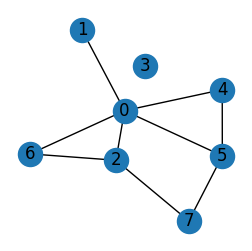

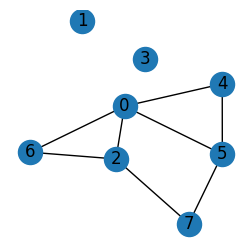

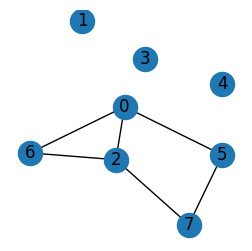

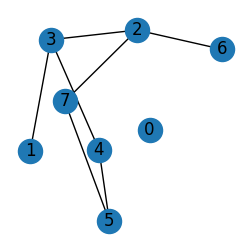

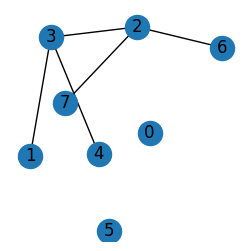

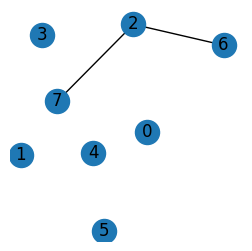

In [73]:
for i in range(2):
    observation , info = env.reset()
    print(observation.nodes)
    print(observation.edges)
    terminated = False
    while terminated is False:
        print(info['node_action_mask'])
        action = env.action_space.sample(mask=info['node_action_mask'])
        observation, reward, terminated, truncated, info = env.step(action)
        print(action,reward)
    env.reset()